Exploring similarities of DVs and clustering

In [ ]:
# !brew install libomp
# !pip install scikit_posthocs

In [1]:
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import resample
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp
from kneed import KneeLocator
import shap
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from hmmlearn.hmm import GaussianHMM
import logging
import xgboost as xgb

print(os.getcwd())
# os.chdir('../')
# print(os.getcwd())

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1/Python
/Users/bb320/Library/CloudStorage/GoogleDrive-burint@bnmanalytics.com/My Drive/Imperial/01_Projects/TeamofRivals/Analysis/Con2vec-1


Data prep

In [2]:
def data_prep(df):
    df = df[['groupId',
    'playerId',
    'PostDiscussionGeneral_raw_discussionDepth',
    'PostDiscussionGeneral_raw_discussionDisagreement',
    'PostDiscussionGeneral_raw_discussionEnjoy',
    'PostDiscussionGeneral_raw_discussionTension',
    'PostDiscussionGeneral_raw_selfAnxious',
    'PostDiscussionGeneral_raw_selfInsight',
    'PostDiscussionGeneral_raw_selfLearned',
    'PostDiscussionGeneral_raw_selfSpeakUp',
    'PostDiscussionGeneral_raw_selfVoice',
    'PostDiscussionPerceptionOfOthers_raw_defensive',
    'PostDiscussionPerceptionOfOthers_raw_liking',
    'PostDiscussionPerceptionOfOthers_raw_partnerListening',
    'PostDiscussionPerceptionOfOthers_raw_partnerPerspectiveTaking',
    'PostDiscussionPerceptionOfOthers_raw_partnerTalking',
    'PostDiscussionPerceptionOfOthers_raw_polite',
    'PostDiscussionPerceptionOfOthers_raw_selfPerspectiveTaking',
    'deal_sheet_agreement_binary',
    'post_negotiation_conflict_1',
    'post_negotiation_conflict_2',
    'post_negotiation_conflict_3',
    'post_negotiation_conflict_4',
    'post_negotiation_decision_leadership_1',
    'post_negotiation_decision_leadership_2',
    'post_negotiation_goal_similarity',
    'post_negotiation_viability_1',
    'post_negotiation_viability_2',
    'role']]


    df.columns = ['groupId',
    'playerId',
    'discussionDepth',
    'discussionDisagreement',
    'discussionEnjoy',
    'discussionTension',
    'selfAnxious',
    'selfInsight',
    'selfLearned',
    'selfSpeakUp',
    'selfVoice',
    'defensive',
    'liking',
    'partnerListening',
    'partnerPerspectiveTaking',
    'partnerTalking',
    'polite',
    'selfPerspectiveTaking',
    'agreement_binary',
    'conflict_1',
    'conflict_2',
    'conflict_3',
    'conflict_4',
    'decision_leadership_1',
    'decision_leadership_2',
    'goal_similarity',
    'viability_1',
    'viability_2',
    'role']


    df['agreement_binary'] = df['agreement_binary'].map({'Yes': 1, 'No': 0})
    df = df.dropna()
    df['discussionTension'] = pd.to_numeric(df['discussionTension'].replace('1S', 1))
    df['discussionTension'].unique()

    # before dropping payer and groupIDs. All individual level metrics must be averages at group level
    df = df.drop(['role', 'playerId'], axis=1)

    return df

Between conversation segmentation

In [3]:
def identify_principal_components(df, variables, max_components=None):
    # Drop rows with NaN values
    df = df.dropna(subset=variables)
    
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[variables])
    
    # Perform PCA
    pca = PCA()
    pca.fit(standardized_data)
    
    # Determine the number of components to retain (explaining 95% variance or max_components)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    num_components = np.argmax(cumulative_variance >= 0.95) + 1
    if max_components:
        num_components = min(num_components, max_components)
    
    # Apply PCA with selected components
    pca = PCA(n_components=num_components)
    reduced_data = pca.fit_transform(standardized_data)
    
    # Identify variable groupings based on factor loadings
    loadings = pd.DataFrame(pca.components_.T, index=variables, columns=[f'PC{i+1}' for i in range(num_components)])
    print("PCA Factor Loadings:\n", loadings)
    
    # Display explained variance for each component and cumulative variance
    for i in range(min(3, len(explained_variance_ratio))):
        print(f"PC{i+1} explains: {explained_variance_ratio[i] * 100:.2f}%")
    print(f"Cumulative variance explained by the first {num_components} PCs: {cumulative_variance[num_components-1] * 100:.2f}%")
    
    return reduced_data, loadings, df, explained_variance_ratio, cumulative_variance

In [4]:
def evaluate_clustering_metrics(reduced_data, max_clusters=10):
    
    """Runs bootstrapped feature selection to determine stability of feature importance per cluster.
    Computes Frequency and Mean SHAP Importance per feature and per cluster."""
    
    metrics_summary = []
    K = range(2, max_clusters + 1)

    logging.info("Evaluating clustering metrics...")

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(reduced_data)
        labels = kmeans.labels_
        metrics_summary.append({
            'k': k,
            'Silhouette Score': silhouette_score(reduced_data, labels),
            'Davies-Bouldin Index': davies_bouldin_score(reduced_data, labels),
            'Calinski-Harabasz Index': calinski_harabasz_score(reduced_data, labels),
            'Distortion': np.sum(np.min(cdist(reduced_data, kmeans.cluster_centers_, 'euclidean'), axis=1))
        })

    # Determine optimal k based on averaging multiple metrics
    optimal_k = int(np.mean([
        max(metrics_summary, key=lambda x: x['Silhouette Score'])['k'],
        min(metrics_summary, key=lambda x: x['Davies-Bouldin Index'])['k'],
        max(metrics_summary, key=lambda x: x['Calinski-Harabasz Index'])['k'],
        min(metrics_summary, key=lambda x: x['Distortion'])['k']
    ]))

    logging.info(f"Optimal number of clusters determined: {optimal_k}")
    return optimal_k, metrics_summary

In [5]:
def perform_kmeans_clustering(reduced_data, optimal_k):
    """Performs K-means clustering with the optimal number of clusters."""
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(reduced_data)
    return kmeans.labels_

def compute_cluster_stability(reduced_data, clusters, optimal_k, n_bootstrap=100):
    """Performs bootstrapped cluster stability analysis using the Adjusted Rand Index (ARI)."""
    logging.info("Performing cluster stability analysis...")
    
    ari_scores = [
        adjusted_rand_score(clusters, KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
                            .fit_predict(resample(reduced_data))[:len(clusters)])
        for _ in range(n_bootstrap)
    ]

    mean_ari = np.mean(ari_scores)
    logging.info(f"Average Adjusted Rand Index (Cluster Stability): {mean_ari:.2f}")
    return mean_ari

In [6]:
def feature_stability_bootstrap(df, variables, clusters, n_feature_bootstrap):
    """
    Runs bootstrapped feature selection to determine stability of feature importance
    separately for each cluster and appends results into a single DataFrame.
    """
    all_cluster_results = []  # List to store results across clusters
    success_count, failure_count = 0, 0  # Track iteration success/failures
    feature_positive_shap = {feature: [] for feature in variables}  # Store positive SHAP values
    feature_negative_shap = {feature: [] for feature in variables}  # Store negative SHAP values

    for cluster in np.unique(clusters):
        print(f"Processing Cluster {cluster}...")  # Track progress

        feature_counts = {feature: 0 for feature in variables}  # Frequency of feature selection
        feature_importance_scores = {feature: [] for feature in variables}  # SHAP scores storage

        for _ in range(n_feature_bootstrap):
            sampled_features = np.random.choice(variables, size=max(5, int(len(variables) * 0.8)), replace=True)
            X = df[sampled_features].values.astype(np.float32)
            y = (clusters == cluster).astype(int)  # Binary classification: Is this cluster or not?

            try:
                # Train XGBoost model
                dtrain = xgb.DMatrix(X, label=y)
                params = {
                    'objective': 'binary:logistic',
                    'eval_metric': 'logloss'
                }
                model = xgb.train(params, dtrain, num_boost_round=100)

                # SHAP Analysis
                explainer = shap.Explainer(model)
                shap_values = explainer(X).values
                
                # Handle SHAP multi-class case
                if len(shap_values.shape) == 3:
                    predicted_classes = model.predict(dtrain).astype(int)
                    indices = np.arange(shap_values.shape[0])
                    shap_values = np.take_along_axis(shap_values, predicted_classes[:, np.newaxis], axis=2).squeeze()
                
                feature_importance_boot = pd.DataFrame(shap_values, columns=sampled_features).abs().mean()
                
                # Select **top 5 features by absolute SHAP values** (to include large positive & negative values)
                top_features = feature_importance_boot.abs().nlargest(5).index

                # Store frequency and SHAP scores
                for feature in top_features:
                    feature_counts[feature] += 1
                    feature_importance_scores[feature].append(abs(feature_importance_boot[feature]))  # Absolute mean SHAP
                    
                    feature_values = shap_values[:, list(sampled_features).index(feature)]
                    feature_positive_shap[feature].append(np.mean(feature_values[feature_values > 0]) if np.any(feature_values > 0) else np.nan)
                    feature_negative_shap[feature].append(np.mean(feature_values[feature_values < 0]) if np.any(feature_values < 0) else np.nan)



                success_count += 1  # Successful iteration
            except Exception as e:
                failure_count += 1  # Failed iteration
                continue  # Skip iteration
                
        # Convert feature importance scores to DataFrame
        feature_importance_df = pd.DataFrame.from_dict(feature_importance_scores, orient='index')
        feature_importance_df = feature_importance_df.apply(pd.to_numeric, errors='coerce')

        feature_positive_df = pd.DataFrame.from_dict(feature_positive_shap, orient='index')
        feature_positive_df = feature_positive_df.apply(pd.to_numeric, errors='coerce')

        feature_negative_df = pd.DataFrame.from_dict(feature_negative_shap, orient='index')
        feature_negative_df = feature_negative_df.apply(pd.to_numeric, errors='coerce')

        # Compute mean SHAP importance per feature for this cluster
        mean_shap_importance = feature_importance_df.mean(axis=1, skipna=True)
        mean_positive_shap = feature_positive_df.mean(axis=1, skipna=True)
        mean_negative_shap = feature_negative_df.mean(axis=1, skipna=True)

        # Store results per cluster
        cluster_results = pd.DataFrame({
            'Cluster': cluster,
            'Feature': list(feature_counts.keys()),
            'Frequency': list(feature_counts.values()),
            'Mean SHAP (Absolute)': [mean_shap_importance.get(f, 0) for f in feature_counts.keys()],
            'Mean Positive SHAP': [mean_positive_shap.get(f, 0) for f in feature_counts.keys()],
            'Mean Negative SHAP': [mean_negative_shap.get(f, 0) for f in feature_counts.keys()]
        })

        all_cluster_results.append(cluster_results)

    # Combine all results
    feature_stability_df = pd.concat(all_cluster_results, ignore_index=True)
    
    print(f"Feature bootstrapping completed: {success_count} successful, {failure_count} failed iterations.")
    
    feature_stability_df = feature_stability_df.sort_values(
        by=['Cluster', 'Frequency', 'Mean SHAP (Absolute)'],
        ascending=[True, False, False]).reset_index(drop=True)

    # Save output
    # feature_stability_df.to_csv('./Output/Clustering/feature_stability_by_cluster.csv', index=False)

    return feature_stability_df

In [7]:
def visualize_clusters(reduced_data, df, custom_colors=None, save_path=None):
    """Generates a t-SNE plot to visualize clustering results."""
    logging.info("Generating cluster visualization...")

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(reduced_data)
    
    plt.figure(figsize=(12, 10))
    
    unique_clusters = sorted(df['Cluster'].unique(), key=lambda x: list(df['Cluster']).index(x))
    cluster_centroids = {cluster: tsne_results[df['Cluster'] == cluster].mean(axis=0) for cluster in unique_clusters}

    if custom_colors is None:
        unique_clusters = sorted(df['Cluster'].unique(), key=lambda x: list(df['Cluster']).index(x))
        custom_colors = {cluster: color for cluster, color in zip(unique_clusters, sns.color_palette("husl", len(unique_clusters)))}
    
    # Draw lines from each point to its centroid
    for i, cluster in enumerate(df['Cluster']):
        plt.plot([tsne_results[i, 0], cluster_centroids[cluster][0]], 
                 [tsne_results[i, 1], cluster_centroids[cluster][1]], 
                 color=custom_colors[cluster], alpha=0.3, linewidth=0.7)  # Slightly transparent line
        
    scatter = sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=df['Cluster'],
        palette=custom_colors,
        s=100,
        alpha=0.7,
        edgecolor='white',
        linewidth=0.60
    )

    plt.xlabel('t-SNE Component 1', fontsize=20)
    plt.ylabel('t-SNE Component 2', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(title='', fontsize=16)
    plt.grid(False)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [8]:
def clustering_pipeline(reduced_data, df, variables, max_clusters=10, n_bootstrap=100, 
                        n_feature_bootstrap=200, custom_colors=None, cluster_names=None):
    """
    Clustering pipeline that determines optimal clusters, performs K-means, 
    evaluates stability, and visualizes the results.
    """
    
    # Find the optimal number of clusters
    optimal_k, metrics_summary = evaluate_clustering_metrics(reduced_data, max_clusters)
    
    # Perform K-Means Clustering
    clusters = perform_kmeans_clustering(reduced_data, optimal_k)

    # Assign cluster names if provided
    if cluster_names is None or len(cluster_names) != optimal_k:
        cluster_names = {i: f"Cluster {i}" for i in range(optimal_k)}  # Default: Cluster 0, Cluster 1, etc.
    else:
        cluster_names = {i: cluster_names[i] for i in range(optimal_k)}

    df['Cluster'] = [cluster_names[label] for label in clusters]  # Assign names

    # Evaluate Cluster Stability
    ari_score = compute_cluster_stability(reduced_data, clusters, optimal_k, n_bootstrap)

    # Feature Importance Stability
    feature_stability_df = feature_stability_bootstrap(df, variables, clusters, n_feature_bootstrap)

    # Visualize Clusters
    visualize_clusters(reduced_data, df, custom_colors)

    return df, metrics_summary, ari_score, feature_stability_df

In [9]:
df_raw = pd.read_csv('wbl_05_22_super_sabbatical_processed.csv')
df = data_prep(df_raw)

df = df.groupby('groupId').mean().reset_index()
groupId = df['groupId'] # Saving to merge back in later to text data
df_num = df.drop('groupId', axis=1)

/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_3793/3874688650.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agreement_binary'] = df['agreement_binary'].map({'Yes': 1, 'No': 0})


In [ ]:
# Get principal components
reduced_data, loadings, df_pca, explained_variance_ratio, cumulative_variance = identify_principal_components(df_num, list(df_num), max_components=50)
loadings.to_csv('./Output/Clustering/pca_loadings.csv')

Evaluating clustering metrics...
Optimal number of clusters determined: 2
Performing cluster stability analysis...
Average Adjusted Rand Index (Cluster Stability): 0.00


Processing Cluster 0...
Processing Cluster 1...


Generating cluster visualization...


Feature bootstrapping completed: 400 successful, 0 failed iterations.


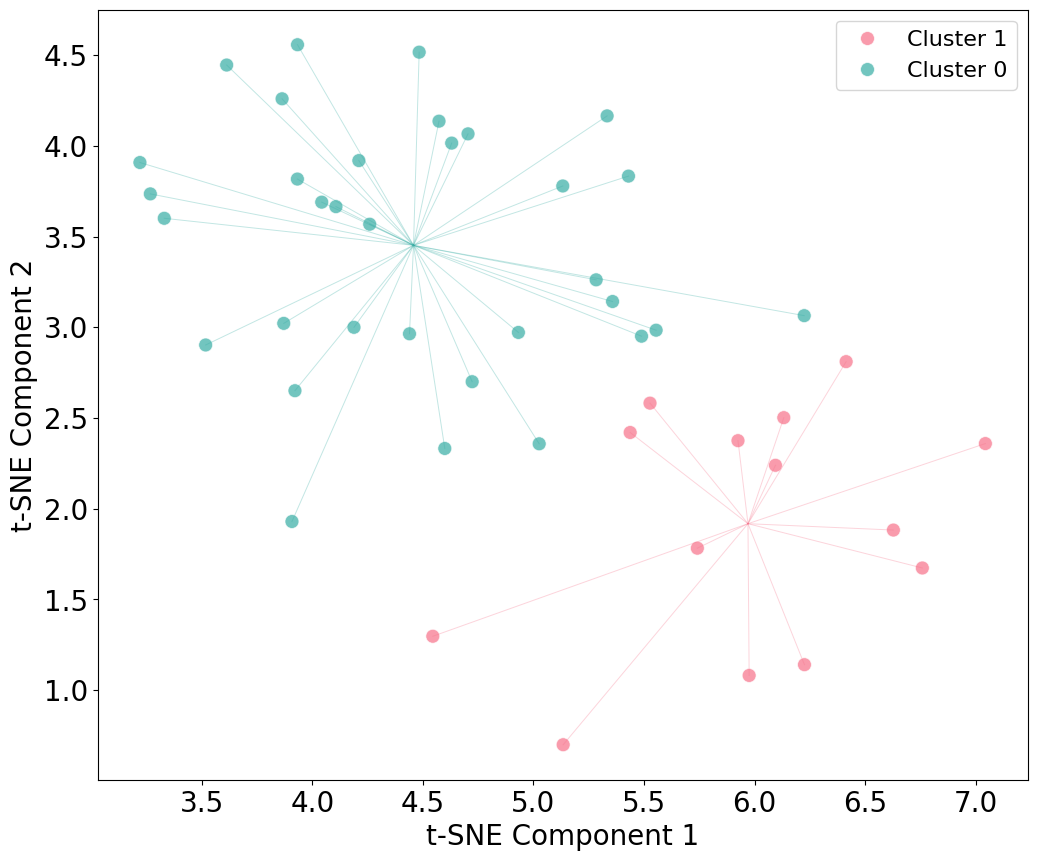

In [12]:
df, metrics_summary, ari_score, feature_stability_df = clustering_pipeline(
    reduced_data, df=df_pca, variables=list(df_num),
    max_clusters=3, n_bootstrap=100, n_feature_bootstrap=200,
    custom_colors=None, cluster_names=None)

feature_stability_df.to_clipboard()

Evaluating clustering metrics...
Optimal number of clusters determined: 2
Performing cluster stability analysis...
Average Adjusted Rand Index (Cluster Stability): 0.00


Processing Cluster 0...
Processing Cluster 1...


Generating cluster visualization...


Feature bootstrapping completed: 400 successful, 0 failed iterations.


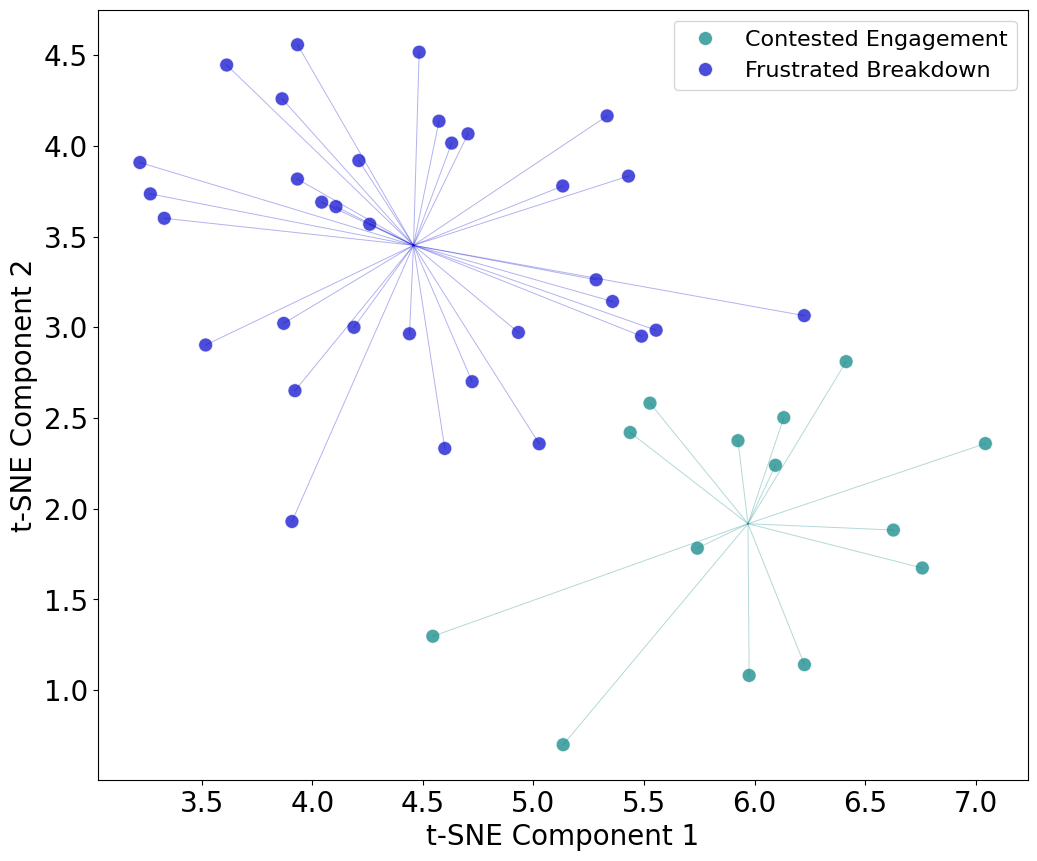

In [11]:

# Define custom names and colours for clustering chart
cluster_names = ["Frustrated Breakdown", "Contested Engagement"]
custom_colors = {
    "Frustrated Breakdown": "#0000cd",
    "Contested Engagement": "#008080"
    # "Open Debate": "#c71585"
}
df, metrics_summary, ari_score, feature_stability_df = clustering_pipeline(
    reduced_data, df_pca, list(df_num),
    max_clusters=3, n_bootstrap=100, 
    cluster_names=cluster_names, custom_colors = custom_colors
)

Segmenting conversations by conflict cluster

In [13]:
df_text = pd.read_csv('./Output/super_May22/Text_agg.csv')
list(df_text)
print(df_text.shape)


(4774, 15)


In [14]:
group_conflicts = df.copy()
group_conflicts['groupId'] = groupId

# print(group_conflicts['groupId'].shape, groupId.shape)
# Extract the last 6 characters from PairID and groupId
df_text['MergeKey'] = df_text['PairID'].str[-6:]
group_conflicts['MergeKey'] = group_conflicts['groupId'].str[-6:]

# Perform a left join
merged_data = df_text.merge(group_conflicts[['MergeKey', 'Cluster']], on='MergeKey', how='left')
print(merged_data.shape)
merged_data.to_clipboard()

(4774, 17)


In [15]:
# Normalize the features
scaler = MinMaxScaler()
merged_data[['word_count_scaled', 'Sentiment_scaled', 'Contested_scaled']] = scaler.fit_transform(
    merged_data[['word_count', 'Sentiment', 'Contested']]
)

In [16]:
# Function to create a Left-to-Right transition matrix
def left_to_right_transition_matrix(n_states):
    """Create a Left-to-Right transition matrix for HMM."""
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        if i < n_states - 1:
            transition_matrix[i, i] = 0.7  # Self-transition probability
            transition_matrix[i, i + 1] = 0.3  # Forward transition probability
        else:
            transition_matrix[i, i] = 1.0  # Last state stays in itself
    return transition_matrix

# Function to enforce varying number of stages using BIC
def find_optimal_hmm(features, min_states=2, max_states=5):
    best_bic = float('inf')
    best_model = None
    best_num_states = None
    for n_states in range(min_states, max_states + 1):
        try:
            # Initialize HMM with Left-to-Right constraints
            hmm_model = GaussianHMM(n_components=n_states, covariance_type="diag", random_state=42)
            hmm_model.startprob_ = np.zeros(n_states)
            hmm_model.startprob_[0] = 1.0  # Start always from the first state
            hmm_model.transmat_ = left_to_right_transition_matrix(n_states)
            hmm_model.fit(features)
            
            # Compute BIC
            n_params = (
                n_states ** 2 +  # Transition probabilities
                n_states * features.shape[1] * 2 +  # Means and variances
                n_states  # Initial probabilities
            )
            log_likelihood = hmm_model.score(features)
            bic = -2 * log_likelihood + n_params * np.log(features.shape[0])
            
            if bic < best_bic:
                best_bic = bic
                best_model = hmm_model
                best_num_states = n_states
        except Exception:
            # Ignore convergence errors
            continue
    return best_model, best_num_states

# Enforce sequential order for StageCluster
def enforce_sequential_order(df, cluster_col='StageCluster'):
    """
    Enforce sequential order for StageCluster within each conversation (PairID).
    Adjusts StageCluster so it only progresses forward or stays the same.
    """
    corrected_clusters = []
    
    for pair_id, group in df.groupby('PairID'):
        current_max = -1  # Track the maximum StageCluster seen so far
        corrected = []

        for cluster in group[cluster_col]:
            if cluster >= current_max:
                current_max = cluster  # Allow progression or staying the same
            corrected.append(current_max)  # Enforce monotonic progression
        
        corrected_clusters.extend(corrected)
    
    df[cluster_col] = corrected_clusters
    return df

In [17]:
# Segment each conversation
stages = []
for pair_id, group in merged_data.groupby('PairID'):
    # Extract features
    features = group[['word_count_scaled', 'Sentiment_scaled', 'Contested_scaled']].values

    # Find the optimal HMM for this conversation
    hmm_model, n_states = find_optimal_hmm(features, max_states=4)

    if hmm_model:
        # Predict stages with the best HMM
        group['StageCluster'] = hmm_model.predict(features)

        # Map clusters to generic stage names
        group['Stage'] = group['StageCluster'].map(lambda x: f"Stage {x + 1}")
    else:
        group['StageCluster'] = -1
        group['Stage'] = "Unclassified"

    stages.append(group)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Model is not converging.  Current: 372.4900306935946 is not greater than 372.55778485148363. Delta is -0.06775415788905548
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' cont

In [18]:
# Combine processed conversations
data_segmented = pd.concat(stages, ignore_index=True)

# Enforce sequential order on StageCluster
data_segmented = enforce_sequential_order(data_segmented, cluster_col='StageCluster')

# Update Stage labels based on corrected clusters
data_segmented['Stage'] = data_segmented['StageCluster'].map(lambda x: f"Stage {x + 1}")

In [19]:
# print(list(data_segmented))
# Summarize conversation stages for each conflict group
summary = (
    data_segmented.groupby(['Cluster', 'StageCluster'])
    .agg(
        # avg_turns=('Turn', lambda x: np.mean(len(x.unique()))),  # Average count of unique turns
        # std_turns=('Turn', lambda x: np.std(len(x.unique()))),
        avg_turns=('Turn', lambda x: np.mean([len(list(g)) for _, g in x.groupby(x)])),
        std_turns=('Turn', lambda x: np.std([len(list(g)) for _, g in x.groupby(x)])),
        # sum_wordcount=('word_count', 'sum'),
        avg_wordcount=('word_count', 'mean'),
        std_wordcount=('word_count', 'std'),
        avg_sentiment=('Sentiment', 'mean'),
        std_sentiment=('Sentiment', 'std'),
        avg_contested=('Contested', 'mean'),
        std_contested=('Contested', 'std')
        # typical_start_time=('Start Time', 'mean'),
        # typical_end_time=('End Time', 'mean')
    )
    .reset_index()
)
# print(summary)
# turn_counts = data_segmented.groupby(['Cluster', 'StageCluster', 'PairID']).size().reset_index(name='turn_counts')
# print(turn_counts)
# avg_turns = turn_counts.groupby(['Cluster', 'StageCluster'])['turn_counts'].mean().reset_index(name='avg_turn_counts')
# std_turns = turn_counts.groupby(['Cluster', 'StageCluster'])['turn_counts'].std().reset_index(name='std_turn_counts')
# print(avg_turns)
# summary['avg_duration'] = summary['typical_end_time'] - summary['typical_start_time']
# summary['avg_turns'] = avg_turns['avg_turn_counts']
# summary['std_turns'] = std_turns['std_turn_counts']

summary = summary.melt(id_vars= ['Cluster', 'StageCluster'] )
summary = summary.pivot(index = ['Cluster', 'variable'],columns='StageCluster')
summary

value                                 
StageCluster                     0          1          2          3
Cluster   variable                                                 
Cluster 0 avg_contested   0.001132   0.317769   0.274667   0.323535
          avg_sentiment   0.207543   0.150392   0.126451   0.142052
          avg_turns       4.888889  12.435185  11.009615   3.524096
          avg_wordcount  20.250000  23.803425  23.365066  18.887179
          std_contested   0.005685   0.462995   0.443011   0.464706
          std_sentiment   0.256094   0.234444   0.237236   0.245061
          std_turns       3.634539   9.720419   7.263575   2.383937
          std_wordcount  40.969361  49.646276  43.418373  46.559260
Cluster 1 avg_contested   0.001756   0.286029   0.333723   0.439261
          avg_sentiment   0.103389   0.099086   0.150687   0.073955
          avg_turns       1.578947   5.682927   4.098765   4.833333
          avg_wordcount  31.088889  20.446352  22.966867  18.346207
          std_contested   0.015125   0.449493   0.467873   0.491665
          std_sentiment   0.234653   0.199959   0.258579   0.234231
          std_turns       1.653782   3.264286   1.902597   3.163156
          std_wordcount  33.922464  44.501133  50.287050  35.925108

In [40]:
# Save the summary
data_segmented.to_csv("./Output/Clustering/Segmented_Conversations_With_Conflicts.csv", index=False)
summary.to_csv("./Output/Clustering/Conflict_Group_Stage_Summary.csv")

/var/folders/pz/gk2tz1l92yd7r5jl_7s8l8d00000gp/T/ipykernel_3793/228932111.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


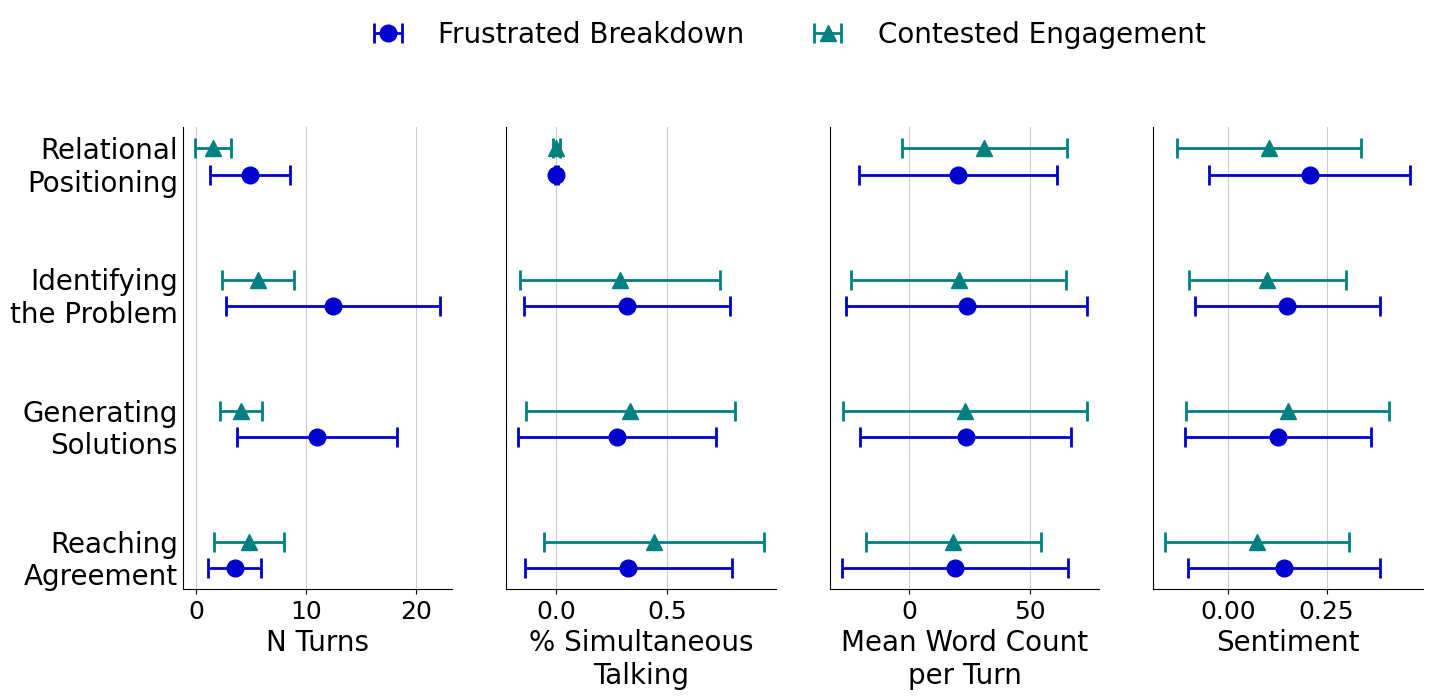

In [39]:
# Load the CSV file
file_path = "./Output/Clustering/Conflict_Group_Stage_Summary.csv"
summary = pd.read_csv(file_path, skiprows=2)

# Rename columns appropriately
summary.rename(columns={'Unnamed: 0': 'Cluster', 'variable': 'Variable', 
                        'Unnamed: 2': 0, 'Unnamed: 3': 1, 'Unnamed: 4': 2, 'Unnamed: 5': 3}, inplace=True)

# Melt the DataFrame to long format for easier plotting
summary = summary.melt(id_vars=['Cluster', 'Variable'], var_name='Stage', value_name='Value')

# Convert 'Stage' column to numeric
summary['Stage'] = summary['Stage'].astype(int)

# Extract standard deviation rows
std_summary = summary[summary['Variable'].str.startswith('std_')].copy()
std_summary['Variable'] = std_summary['Variable'].str.replace('std_', 'avg_')

# Merge standard deviations back into the main dataframe
summary = summary.merge(std_summary, on=['Cluster', 'Variable', 'Stage'], suffixes=('', '_Std'))

# Correct the stage order so that the labels match the data points
stage_order = {0: 3, 1: 2, 2: 1, 3: 0}
summary["Stage"] = summary["Stage"].map(stage_order)

# Define formatted stage labels with multi-line formatting
formatted_stage_labels = {
    0: "Reaching\nAgreement",
    1: "Generating\nSolutions",
    2: "Identifying\nthe Problem",
    3: "Relational\nPositioning"
}

# Define cluster names, colors, and marker styles
cluster_names = {"Cluster 0": "Frustrated Breakdown", "Cluster 1": "Contested Engagement"}
colors = {"Frustrated Breakdown": "#0000cd", "Contested Engagement": "#008080"}
markers = {"Frustrated Breakdown": "o", "Contested Engagement": "^"}
offset = 0.1  
larger_marker_size = 12  

# Define metric order and labels with multi-line formatting
ordered_metrics = ["avg_turns", "avg_contested", "avg_wordcount", "avg_sentiment"]
ordered_std_metrics = ["std_turns", "std_contested", "std_wordcount", "std_sentiment"]
metric_labels = {
    "avg_turns": "N Turns",
    "avg_contested": "% Simultaneous\nTalking",
    "avg_wordcount": "Mean Word Count\nper Turn",
    "avg_sentiment": "Sentiment"
}


# Create the figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True, gridspec_kw={'wspace': 0.2})

for i, (metric, std_metric) in enumerate(zip(ordered_metrics, ordered_std_metrics)):
    ax = axes[i]
    subset = summary[summary['Variable'] == metric]
    
    for cluster in subset['Cluster'].unique():
        cluster_name = cluster_names[cluster]  # Rename clusters
        cluster_subset = subset[subset['Cluster'] == cluster]
        ax.errorbar(
            cluster_subset['Value'],
            cluster_subset['Stage'] - (offset if cluster_name == "Frustrated Breakdown" else -offset),  
            xerr=cluster_subset['Value_Std'],
            fmt=markers[cluster_name],  # Use different marker styles
            color=colors[cluster_name],
            markersize=larger_marker_size,  # Larger markers
            label=cluster_name if i == 0 else "",
            capsize=7,  # Larger caps for error bars
            capthick=2,  # Thicker error bar caps
            elinewidth=2  # Increase error bar line thickness
        )

    ax.set_xlabel(metric_labels[metric], fontsize=20)
    ax.tick_params(axis='x', labelsize=18)  # Keep x-axis ticks
    ax.tick_params(axis='y', length=0)  # Remove only the y-axis tick marks
    ax.set_yticks(list(formatted_stage_labels.keys()))
    ax.set_yticklabels([formatted_stage_labels[stage] for stage in formatted_stage_labels], fontsize=20)
    
    
    # Remove all horizontal grid lines and keep only vertical grid lines
    ax.grid(False)  # Remove all grid lines first
    ax.grid(axis='x', color='grey', alpha=0.4)  # Add only vertical lines

    # Remove top and right borders of each subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Remove y-axis title
axes[0].set_ylabel("")

# Move legend to a more central position
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=20, frameon=False)

# Improve layout
plt.tight_layout()
plt.show()